In [2]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB MIG 2g.20gb


In [3]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [4]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [5]:
import evaluate
rouge = evaluate.load("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode predictions and references
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute ROUGE scores
    result = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])

    # If 'rouge2' returns a dict (e.g., with precision, recall, fmeasure)
    if isinstance(result["rouge2"], dict):
        return {
            "rouge2_precision": round(result["rouge2"]["precision"], 4),
            "rouge2_recall": round(result["rouge2"]["recall"], 4),
            "rouge2_fmeasure": round(result["rouge2"]["fmeasure"], 4),
        }
    else:
        # If it returns a float, just return F1 as rouge2
        return {
            "rouge2": round(result["rouge2"], 4)
        }


In [6]:
from transformers import ViTImageProcessor
feature_extractor = ViTImageProcessor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

In [7]:
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
df=  pd.read_csv("/scratch/njanivar/test/flickr8k/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [8]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self, idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")

        # ✅ Let ViTImageProcessor handle all transformations
        pixel_values = self.feature_extractor(images=img, return_tensors="pt").pixel_values

        captions = self.tokenizer(caption,
                                padding='max_length',
                                max_length=self.max_length,
                                truncation=True).input_ids
        captions = [token if token != self.tokenizer.pad_token_id else -100 for token in captions]

        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}

In [9]:
train_dataset = ImgDataset(train_df, root_dir = "/scratch/njanivar/test/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "/scratch/njanivar/test/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

In [10]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

In [11]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
tokenizer.pad_token = tokenizer.eos_token  # common workaround for GPT2
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [12]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    eval_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [13]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/tmp/ipykernel_3099757/2896216190.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.save_model('VIT_large_gpt2')

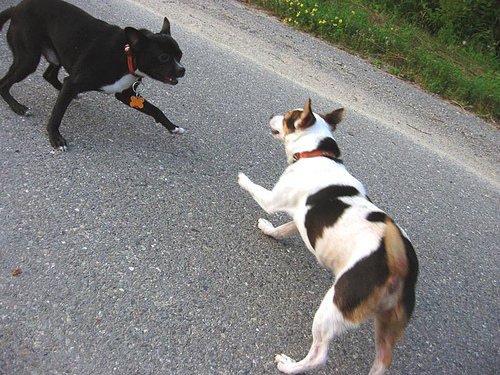

In [ ]:
img =  Image.open("/scratch/njanivar/test/flickr8k/Images/1001773457_577c3a7d70.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:85]+ '\033[0m')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|endoftext|> black brown white black white black black white white black brown black


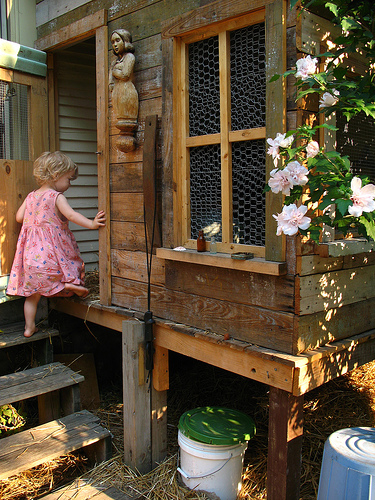

In [ ]:
img =  Image.open("/scratch/njanivar/test/flickr8k/Images/1000268201_693b08cb0e.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:120]+ '\033[0m')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|endoftext|> little in dress pink in of house a . . . in . . yard a of . . , . . house . . a . house the . . is . . on 
